In [4]:
!pip install pycoingecko
!pip3 install pyro-ppl
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import requests
import math
import numpy as np
import pandas as pd
import altair as alt
import warnings
import datetime
import time
import statsmodels.api as sm
import statsmodels.formula.api as smfF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import itertools
from matplotlib.pylab import rcParams
from pycoingecko import CoinGeckoAPI
import jax.numpy as jnp
import numpyro
import jax.random as random


In [6]:
df = pd.read_csv('df_for_pyro_modelling_term_by_rbp.csv')
df = df.set_index('stat_date')
df = df[-365:]
df.head(5)

,daily_new_terminate_rbp,roi,sector_rewards_360d_32gib,sector_initial_pledge_32gib,sector_penalty_32gib,price,total_raw_bytes_power
stat_date,,,,,,,
2022-02-16T00:00:00Z,1.146819e-06,1.165952,0.182084,0.153091,0.070810,22.341526,1.615882e+07
2022-02-17T00:00:00Z,1.218263e-07,1.076243,0.168302,0.153340,0.065451,23.108153,1.616031e+07
2022-02-18T00:00:00Z,2.047383e-07,1.101289,0.172559,0.153641,0.067106,20.506549,1.617919e+07
2022-02-19T00:00:00Z,7.860948e-06,1.065334,0.167173,0.153892,0.065012,21.090336,1.618761e+07
2022-02-20T00:00:00Z,6.871563e-07,1.071752,0.168548,0.154224,0.065546,20.909838,1.618991e+07


In [7]:
import os
from functools import partial
import torch
import seaborn as sns

import pyro
import pyro.distributions as dist

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)


%matplotlib inline
plt.style.use('default')

In [8]:
df["daily_new_terminate_rbp"] = np.log(df["daily_new_terminate_rbp"])

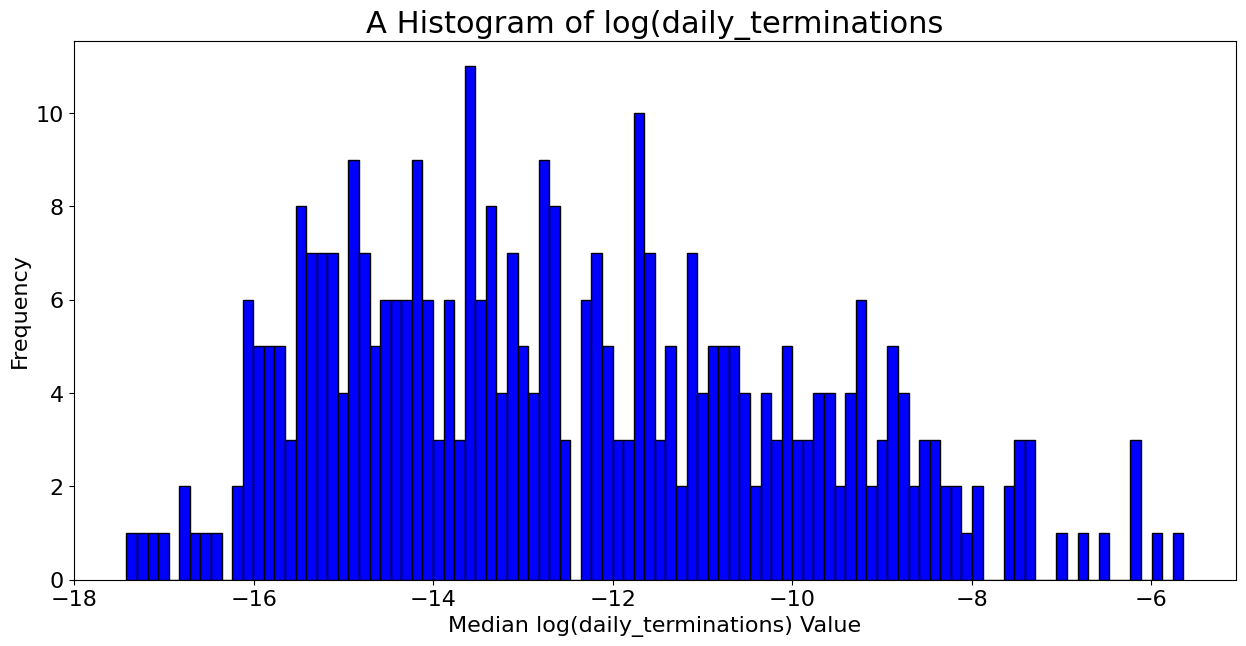

In [9]:
plt.figure(figsize=(15,7))
plt.hist(df["daily_new_terminate_rbp"], bins=100, color="blue", edgecolor="black")
plt.xlabel("Median log(daily_terminations) Value", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of log(daily_terminations", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# data = df[["roi", "sector_rewards_360d_32gib",	"sector_initial_pledge_32gib",	"sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]].values
# data = df[["sector_initial_pledge_32gib","sector_penalty_32gib","price", "daily_new_terminate_rbp"]].values
data = df[["sector_penalty_32gib","price", "daily_new_terminate_rbp"]].values
# data = df[["sector_penalty_32gib", "daily_new_terminate_rbp"]].values


X, y = data[:, :-1], data[:, -1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_train = X
X_test = X

y_train = y
y_test = y

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(365, 2) (365,)
(365, 2) (365,)


In [11]:
# feature_names = ["roi", "sector_rewards_360d_32gib",	"sector_initial_pledge_32gib",	"sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]
# feature_names = ["sector_initial_pledge_32gib",	"sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]
feature_names = ["sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]
# feature_names = ["sector_penalty_32gib", "daily_new_terminate_rbp"]

## Simple Linear Regression

In [12]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [13]:
# data = torch.tensor(df[["roi", "sector_rewards_360d_32gib",	"sector_initial_pledge_32gib",	"sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]].values,
#                         dtype=torch.float)

# data = torch.tensor(df[["sector_initial_pledge_32gib",	"sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]].values,
#                         dtype=torch.float)

data = torch.tensor(df[[	"sector_penalty_32gib",	"price", "daily_new_terminate_rbp"]].values,
                        dtype=torch.float)

# data = torch.tensor(df[[	"sector_penalty_32gib", "daily_new_terminate_rbp"]].values,
#                         dtype=torch.float)

x_data, y_data = data[:, :-1], data[:, -1]

linear_reg_model = PyroModule[nn.Linear](2, 1)

loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 12641.6074
[iteration 0100] loss: 8816.1123
[iteration 0150] loss: 6093.3115
[iteration 0200] loss: 4320.8501
[iteration 0250] loss: 3262.1672
[iteration 0300] loss: 2679.5332
[iteration 0350] loss: 2384.0979
[iteration 0400] loss: 2246.1335
[iteration 0450] loss: 2186.8049
[iteration 0500] loss: 2163.3044
[iteration 0550] loss: 2154.7261
[iteration 0600] loss: 2151.8389
[iteration 0650] loss: 2150.9414
[iteration 0700] loss: 2150.6826
[iteration 0750] loss: 2150.6111
[iteration 0800] loss: 2150.5906
[iteration 0850] loss: 2150.5825
[iteration 0900] loss: 2150.5771
[iteration 0950] loss: 2150.5720
[iteration 1000] loss: 2150.5669
[iteration 1050] loss: 2150.5615
[iteration 1100] loss: 2150.5564
[iteration 1150] loss: 2150.5508
[iteration 1200] loss: 2150.5452
[iteration 1250] loss: 2150.5396
[iteration 1300] loss: 2150.5337
[iteration 1350] loss: 2150.5281
[iteration 1400] loss: 2150.5220
[iteration 1450] loss: 2150.5159
[iteration 1500] loss: 2150.5100
Learned p

In [14]:
# from sklearn.metrics import r2_score

# def plot_all_observations(y_true, y_pred, y_max):
    
#     y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
#     plt.figure(figsize=(15, 5))
#     plt.scatter(y_pred_censored, np.array(linear_reg_model(x_data).detach().cpu().numpy()), c="blue", edgecolor="black", label=f"R^2={round(r2_score(linear_reg_model(x_data).detach().cpu().numpy(), y_pred_censored),2)}")
#     plt.title("Predicted log(daily terminations) vs Actual log(daily terminations)", size=22)
#     plt.xlabel("Predicted log(daily terminations)", size=16)
#     plt.ylabel("Actual log(daily terminations)", size=16)
#     plt.ticklabel_format(style='plain')
#     plt.legend()
    
#     plt.show()
    
    
    
# # Now let's call our function
# y_censor_label = int(y_data.max())
# plot_all_observations(y_data, np.array(linear_reg_model(x_data).detach().cpu().numpy()), y_censor_label)

## GLM with PYRO

In [15]:
import torch
torch.set_default_tensor_type(torch.FloatTensor) 

import pyro
import pyro.distributions as dist

from pyro.infer import MCMC, NUTS

In [16]:
def model_normal(X, y, column_names):
    
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    nsteps = X.shape[0] // 14
    mu = pyro.sample('rw', dist.Normal(loc=0., scale=0.5).expand([nsteps]).independent(1))
    mu = mu.repeat(14)
    mu = torch.cat((mu, mu[-1].repeat(X.shape[0] % 14)))
    linear_combination = mu

    
    
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        

        outcome_dist = dist.Normal(mean, sigma)
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [17]:
SAMPLE_NUMBER = 3000


X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



pyro.clear_param_store()

my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) 


my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()

my_mcmc1.run(X_train_torch, 
             y_train_torch,
             feature_names)

end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [02:06, 24.59it/s, step size=6.30e-01, acc. prob=0.850]

Inference ran for 2.1 minutes


In [18]:
my_mcmc1.summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
             beta_intercept     -0.01      1.00     -0.00     -1.61      1.68   6907.70      1.00
                 beta_price     -0.97      0.03     -0.97     -1.03     -0.92   6343.29      1.00
  beta_sector_penalty_32gib     -1.42      1.01     -1.42     -2.98      0.31   6075.34      1.00
                      rw[0]     -0.28      0.49     -0.27     -1.09      0.49   7269.26      1.00
                      rw[1]     -0.28      0.48     -0.28     -1.08      0.47   6958.51      1.00
                      rw[2]     -0.26      0.49     -0.26     -1.05      0.52   6349.14      1.00
                      rw[3]     -0.31      0.48     -0.30     -1.12      0.47   5949.23      1.00
                      rw[4]     -0.20      0.50     -0.20     -0.95      0.67   3549.09      1.00
                      rw[5]     -0.24      0.48     -0.24     -1.00      0.57   5317.76      1.00
                   

In [19]:
my_dict = my_mcmc1.get_samples()
my_dict['beta_intercept'] = my_dict['rw'].mean(axis = 1)
del my_dict['rw']

In [20]:
beta_df = pd.DataFrame(my_dict)
beta_df.head()

,beta_intercept,beta_price,beta_sector_penalty_32gib,sigma
0,-0.355418,-0.972629,-1.202764,7.009575
1,-0.317832,-0.949521,-1.904771,6.327848
2,-0.224900,-1.007761,-0.419347,7.381684
3,-0.212300,-0.974159,-2.006783,6.317304
4,-0.209072,-0.938551,0.162429,7.036654


In [21]:
def predict_linear_combination(beta_df, X):
    
    coefficients = beta_df.iloc[:, :-1].quantile(0.5)

    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [22]:
def predict_linear_combination_90(beta_df, X):
    
    coefficients = beta_df.iloc[:, :-1].quantile(0.9)

    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination
    
def predict_linear_combination_10(beta_df, X):
    
    coefficients = beta_df.iloc[:, :-1].quantile(0.1)

    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [23]:
linear_combination = predict_linear_combination(beta_df, X_test)
y_pred = linear_combination

In [24]:
from sklearn.metrics import r2_score

def plot_all_observations(y_true, y_pred, y_max):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted daily terminations vs Actual daily terminations", size=22)
    plt.xlabel("Predicted daily terminations", size=16)
    plt.ylabel("Actual daily terminations", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()


def plot_uncensored_observations(y_true, y_pred, y_censor_label):
    
    y_test_uncensored = y_test[y_test<y_censor_label]
    y_pred_uncensored = y_pred[y_test<y_censor_label]
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')
    
    plt.title("Predicted daily terminations vs Actual daily terminations", size=22)
    plt.xlabel("Predicted daily terminations", size=16)
    plt.ylabel("Actual daily terminations", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()

In [25]:
y_censor_label = y_train.max()
# plot_all_observations(y_test, y_pred, y_censor_label)
# plot_uncensored_observations(y_test, y_pred, y_censor_label)

In [26]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(3,1, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
# draw_coefficients(beta_df)

### Scaling the data

In [27]:
from sklearn.preprocessing import StandardScaler


my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

y_censor_label = y_train.max()
y_train_scaled = y_train/y_censor_label

In [28]:
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


pyro.clear_param_store()

my_kernel2 = NUTS(model_normal, max_tree_depth=7)

my_mcmc2 = MCMC(my_kernel2,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [01:43, 29.92it/s, step size=5.29e-01, acc. prob=0.888]

Inference ran for 1.73 minutes


In [29]:
def create_beta_df(beta_df, x_scaler, feature_names):        
    
    i = 0
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):

                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]     
                
                beta_df[col] /= x_scaler.scale_[i]
                i += 1

    return beta_df

In [30]:
my_dict = my_mcmc2.get_samples()
my_dict['beta_intercept'] = my_dict['rw'].mean(axis = 1)
del my_dict['rw']

In [31]:
beta2_df = pd.DataFrame(my_dict)
beta2_df = create_beta_df(beta2_df, my_x_scaler, feature_names)

beta2_df *= y_censor_label 

<ipython-input-26-ea298c2b8bde>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
<ipython-input-26-ea298c2b8bde>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
<ipython-input-26-ea298c2b8bde>:7: UserWarning: 

`distplot` is a deprecated function and will be removed 

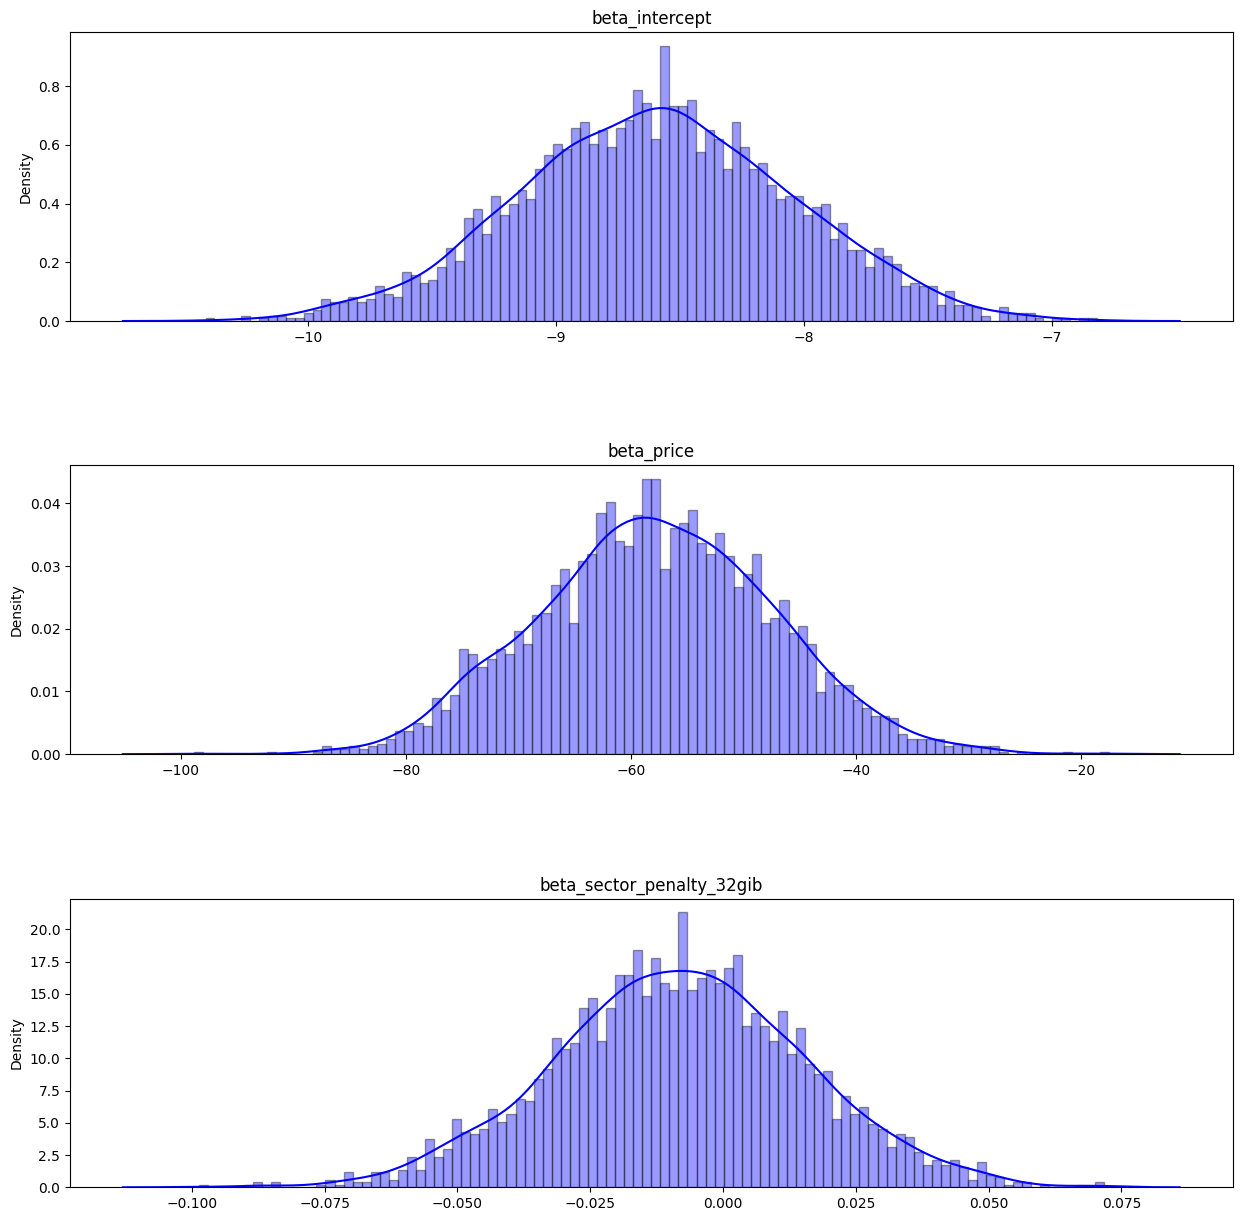

In [32]:
linear_combination = predict_linear_combination(beta2_df, X_test)
y_pred = linear_combination

linear_combination_90 = predict_linear_combination_90(beta2_df, X_test)
y_pred_90 = linear_combination_90

linear_combination_10 = predict_linear_combination_10(beta2_df, X_test)
y_pred_10 = linear_combination_10

# plot_all_observations(y_test, y_pred, y_censor_label)
# plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta2_df)

In [33]:
X_test_counter_factual_3x = X_test.copy()
# X_test_counter_factual_3x[:, 1] = 3*X_test_counter_factual_3x[:, 1]
X_test_counter_factual_3x = (160/90)*X_test_counter_factual_3x


X_test_counter_factual_4x = X_test.copy()
# X_test_counter_factual_4x[:, 1] = 4*X_test_counter_factual_4x[:, 1]
X_test_counter_factual_4x = 4*X_test_counter_factual_4x


X_test_counter_factual_5x = X_test.copy()
# X_test_counter_factual_5x[:, 1] = 5*X_test_counter_factual_5x[:, 1]
X_test_counter_factual_5x= 5*X_test_counter_factual_5x

In [34]:
linear_combination_counter_factual_3x = predict_linear_combination(beta2_df, X_test_counter_factual_3x)
y_pred_counter_factual_3x =  linear_combination_counter_factual_3x
linear_combination_90 = predict_linear_combination_90(beta2_df, X_test_counter_factual_3x)
y_pred__3x_90 = linear_combination_90
linear_combination_10 = predict_linear_combination_10(beta2_df, X_test_counter_factual_3x)
y_pred__3x_10 = linear_combination_10


linear_combination_counter_factual_4x = predict_linear_combination(beta2_df, X_test_counter_factual_4x)
y_pred_counter_factual_4x =  linear_combination_counter_factual_4x
linear_combination_90 = predict_linear_combination_90(beta2_df, X_test_counter_factual_4x)
y_pred__4x_90 = linear_combination_90
linear_combination_10 = predict_linear_combination_10(beta2_df, X_test_counter_factual_4x)
y_pred__4x_10 = linear_combination_10

linear_combination_counter_factual_5x = predict_linear_combination(beta2_df, X_test_counter_factual_5x)
y_pred_counter_factual_5x =  linear_combination_counter_factual_5x
linear_combination_90 = predict_linear_combination_90(beta2_df, X_test_counter_factual_5x)
y_pred__5x_90 = linear_combination_90
linear_combination_10 = predict_linear_combination_10(beta2_df, X_test_counter_factual_5x)
y_pred__5x_10 = linear_combination_10

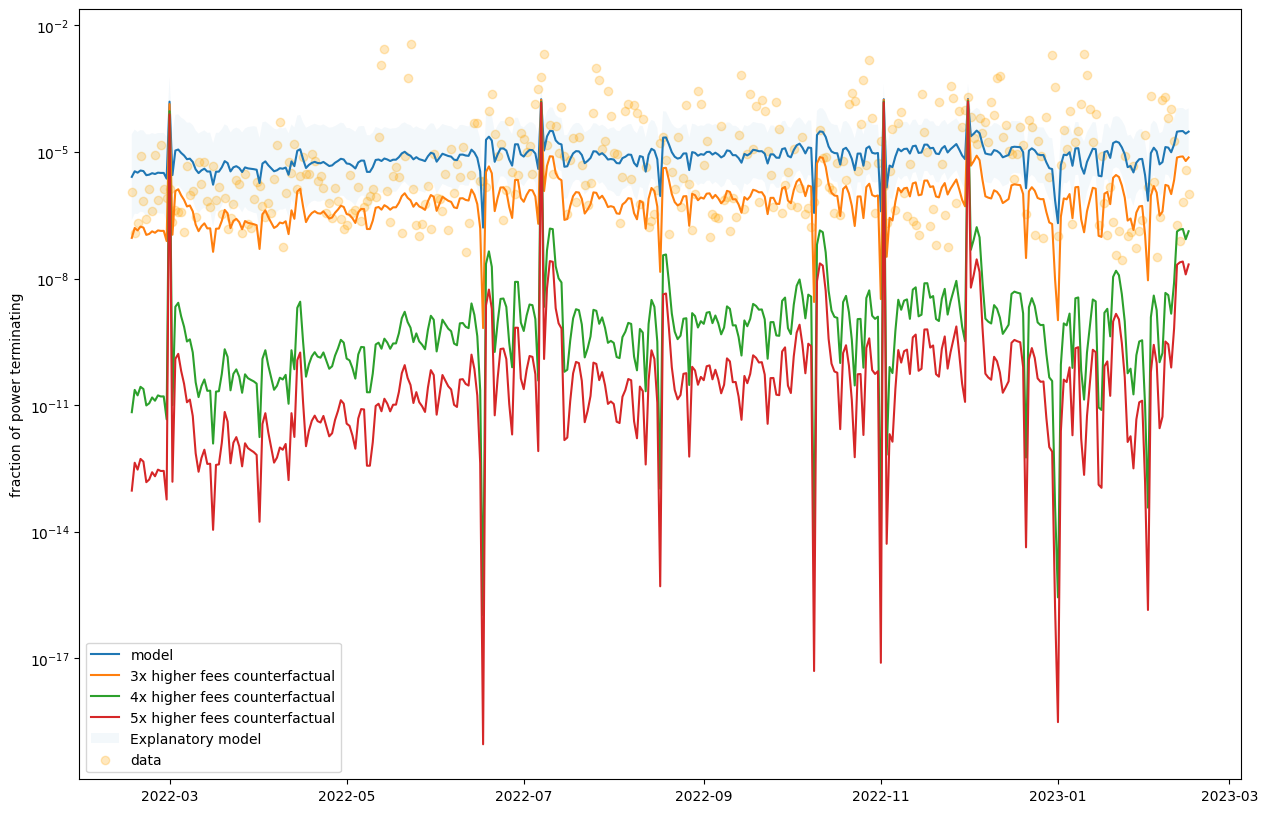

In [35]:
df.index = pd.to_datetime(df.index)
plt.figure(figsize=(15,10))
plt.plot(df.index, np.exp(y_pred), label='model')
plt.plot(df.index, np.exp(y_pred_counter_factual_3x), label='3x higher fees counterfactual')
plt.plot(df.index, np.exp(y_pred_counter_factual_4x), label='4x higher fees counterfactual')
plt.plot(df.index, np.exp(y_pred_counter_factual_5x), label='5x higher fees counterfactual')
plt.fill_between(df.index, np.exp(y_pred_10), 
                 np.exp(y_pred_90), 
                 label='Explanatory model',alpha=0.05,lw=0.5)
# plt.fill_between(df.index, np.exp(y_pred__3x_10), 
#                  np.exp(y_pred__3x_90), 
#                  label='3x Counterfactual',alpha=0.05,lw=0.5)
# plt.fill_between(df.index, np.exp(y_pred__4x_10), 
#                  np.exp(y_pred__4x_90), 
#                  label='4x Counterfactual',alpha=0.05,lw=0.5)
# plt.fill_between(df.index, np.exp(y_pred__5x_10), 
#                  np.exp(y_pred__5x_90), 
#                  label='5x Counterfactual',alpha=0.05,lw=0.5)
plt.scatter(df.index, np.exp(y_test), alpha=0.25,c='orange', label='data')
plt.legend()
plt.ylabel("fraction of power terminating")
plt.yscale('log')
plt.show()

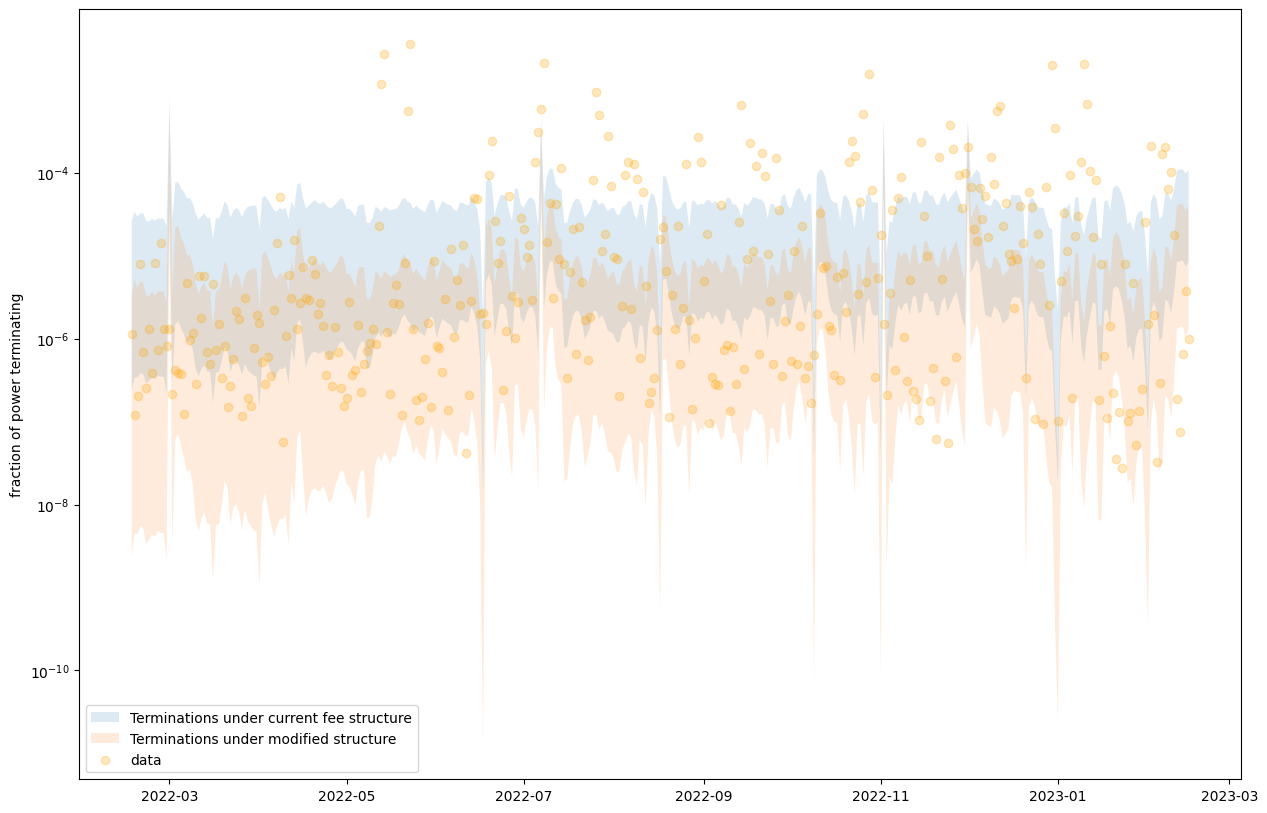

In [36]:
df.index = pd.to_datetime(df.index)
plt.figure(figsize=(15,10))
# plt.plot(df.index, np.exp(y_pred), label='model')
# plt.plot(df.index, np.exp(y_pred_counter_factual_3x), label='3x higher fees counterfactual')
# plt.plot(df.index, np.exp(y_pred_counter_factual_4x), label='4x higher fees counterfactual')
# plt.plot(df.index, np.exp(y_pred_counter_factual_5x), label='5x higher fees counterfactual')
plt.fill_between(df.index, np.exp(y_pred_10), 
                 np.exp(y_pred_90), 
                 label='Terminations under current fee structure',alpha=0.15,lw=0.5)
plt.fill_between(df.index, np.exp(y_pred__3x_10), 
                 np.exp(y_pred__3x_90), 
                 label='Terminations under modified structure',alpha=0.15,lw=0.5)
# plt.fill_between(df.index, np.exp(y_pred__4x_10), 
#                  np.exp(y_pred__4x_90), 
#                  label='4x Counterfactual',alpha=0.15,lw=0.5)
# plt.fill_between(df.index, np.exp(y_pred__5x_10), 
#                  np.exp(y_pred__5x_90), 
#                  label='5x Counterfactual',alpha=0.15,lw=0.5)
plt.scatter(df.index, np.exp(y_test), alpha=0.25,c='orange', label='data')
plt.legend()
plt.ylabel("fraction of power terminating")
plt.yscale('log')
plt.show()

### Using a Gamma distribution

In [37]:
# y_exp = np.exp(y)

# y_train = y_exp
# y_test = y_exp

# y_censor_label = y_train.max()
# y_train_scaled = y_train/y_censor_label

In [38]:
# def model_gamma(X, y, column_names):
#     pyro.enable_validation(True)
    
#     min_value = torch.finfo(X.dtype).eps
#     max_value = torch.finfo(X.dtype).max
    
    
#     intercept_prior = dist.Normal(0.0, 1.0)
#     linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
#     for i in range(X.shape[1]):
#         coefficient_prior = dist.Normal(0.0, 1.0)
#         beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        
#         linear_combination = linear_combination + (X[:, i] * beta_coef)
    
        
#     mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
#     rate = pyro.sample("rate", dist.HalfNormal(scale=10.0)).clamp(min=min_value)
    
#     shape = (mean * rate)
    
    
#     with pyro.plate("data", y.shape[0]):
        
#         outcome_dist = dist.Gamma(shape, rate)
        
#         observation = pyro.sample("obs", outcome_dist, obs=y)

In [39]:
# X_train_torch = torch.tensor(X_train_scaled)
# #X_train_torch[X_train_torch  < 0] = 0.0
# y_train_torch = torch.tensor(y_train_scaled)

# pyro.clear_param_store()

# my_kernel3 = NUTS(model_gamma, max_tree_depth=7)


# my_mcmc3 = MCMC(my_kernel3,
#                 num_samples=SAMPLE_NUMBER,
#                 warmup_steps=100)



# start_time = time.time()
# my_mcmc3.run(X_train_torch,
#              y_train_torch,
#              feature_names)
# end_time = time.time()

# print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

In [40]:
# beta3_df = pd.DataFrame(my_mcmc3.get_samples())
# beta3_df = create_beta_df(beta3_df, my_x_scaler, feature_names)

# y_censor_label = y_train.max()
# beta3_df['beta_intercept'] += np.log(y_censor_label)

In [41]:
# linear_combination = predict_linear_combination(beta3_df, X_test)
# y_pred = np.exp(linear_combination)

# linear_combination_90 = predict_linear_combination_90(beta3_df, X_test)
# y_pred_90 = np.exp(linear_combination_90)

# linear_combination_10 = predict_linear_combination_10(beta3_df, X_test)
# y_pred_10 = np.exp(linear_combination_10)

# # plot_all_observations(y_test, y_pred, y_censor_label)
# # plot_uncensored_observations(y_test, y_pred, y_censor_label)

# draw_coefficients(beta3_df)

In [42]:
# X_test_counter_factual = X_test.copy()
# X_test_counter_factual[:, 1] = 3*X_test_counter_factual[:, 1]

In [43]:
# linear_combination_counter_factual = predict_linear_combination(beta3_df, X_test_counter_factual)
# y_pred_counter_factual =  np.exp(linear_combination_counter_factual)

In [44]:
# df.index = pd.to_datetime(df.index)
# plt.figure(figsize=(15,10))
# plt.plot(df.index, y_pred, label='model')
# plt.plot(df.index, y_pred_counter_factual, label='3x higher fees counterfactual')
# plt.fill_between(df.index, y_pred_10, 
#                  y_pred_90, 
#                  label='Explanatory model',alpha=0.05,lw=0.5,color='blue')
# plt.scatter(df.index, y_exp, alpha=0.25,c='orange', label='data')
# plt.legend()
# plt.ylabel("fraction of power terminating")
# plt.show()

In [45]:
# df.index = pd.to_datetime(df.index)
# plt.figure(figsize=(15,10))
# plt.plot(df.index, y_pred, label='model')
# plt.plot(df.index, y_pred_counter_factual, label='3x higher fees counterfactual')
# plt.fill_between(df.index, y_pred_10, 
#                  y_pred_90, 
#                  label='Explanatory model',alpha=0.05,lw=0.5,color='blue')
# plt.scatter(df.index, y_exp, alpha=0.25,c='orange', label='data')
# plt.yscale('log')
# plt.legend()
# plt.ylabel("fraction of power terminating")
# plt.show()

In [46]:
# df.index = pd.to_datetime(df.index)
# plt.figure(figsize=(15,10))
# plt.plot(df.index, np.exp(predict_linear_combination(beta2_df, X_test)), label='gaussian')
# plt.plot(df.index, np.exp(predict_linear_combination(beta3_df, X_test)), label='gamma')
# plt.scatter(df.index, y_exp, alpha=0.25,c='orange', label='data')
# plt.legend()
# plt.ylabel("fraction of power terminating")
# plt.show()